### Calculating the transect heat fluxes

In [2]:
base = '/g/data/e14/mv7494/access-om2/archive/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
from scipy import stats

from dask.distributed import Client
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:39203 Dashboard: /proxy/44951/status,Cluster Workers: 4 Cores: 16 Memory: 68.72 GB


### Calculate the heat fluxes across the different transects between the ocean basins

In [8]:
%%time
t = np.linspace(0,45,46)
base = '/g/data/e14/mv7494/access-om2/archive/'

for ex in range(2): # loop through CTRL and IAF run
    if ex == 0:
        archive = '1deg_jra55_rdf_branch2000_Control/'
    if ex == 1:
        archive = '1deg_jra55_iaf_branch2000/'
    print(archive)
    # open wmass.nc file 
    wmass = xr.open_mfdataset(base + archive + 'output*/ocean/ocean_wmass.nc')
    
    # add together the different diagnostics from the advection, submeso, gm and diffusive mixing schemes
    temp_yflux_on_nrho = (wmass.temp_yflux_adv_on_nrho + wmass.temp_yflux_submeso_on_nrho + wmass.temp_yflux_gm_on_nrho + wmass.temp_yflux_ndiffuse_on_nrho)
    temp_yflux_on_nrho = (temp_yflux_on_nrho*60*60*24*365).sum(['neutral']).cumsum(['time']).sel(time=slice('1972','2017'))
    
    # additionally I need the temp_xflux data for the ITF transport between Papua and Australia
    temp_xflux_on_nrho = (wmass.temp_xflux_adv_on_nrho + wmass.temp_xflux_submeso_on_nrho + wmass.temp_xflux_gm_on_nrho + wmass.temp_xflux_ndiffuse_on_nrho)
    temp_xflux_on_nrho = (temp_xflux_on_nrho*60*60*24*365).sum(['neutral']).cumsum(['time']).sel(time=slice('1972','2017'))

    if ex == 0:
        temp_yflux_clim = temp_yflux_on_nrho
        temp_xflux_clim = temp_xflux_on_nrho
    if ex == 1:
        temp_yflux = temp_yflux_on_nrho
        temp_xflux = temp_xflux_on_nrho

        
for s in range(7): # loop through the different transects
    if s == 0: 
        print('Test Transect: Southern Ocean into Atlantic + Pacific + Indian')
        print('--- --- --- --- --- --- ---')
        a = temp_yflux_clim.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-280,80)).sum(['grid_xt_ocean']).values
        b =      temp_yflux.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-280,80)).sum(['grid_xt_ocean']).values
    
    # transect from the Southern Ocean into the Atlantic Ocean: 35°S, 70°W - 22°E
    if s == 1: 
        print('Transect   I: Southern Ocean - Atlantic')
        c = temp_yflux_clim.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-65,19)).sum(['grid_xt_ocean']).values
        d =      temp_yflux.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-65,19)).sum(['grid_xt_ocean']).values
    
    # transect from the Southern Ocean into the Pacific Ocean: 35°S
    if s == 2: 
        print('Transect  II: Southern Ocean - Pacific')
        e = temp_yflux_clim.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-220,-65)).sum(['grid_xt_ocean']).values
        f =      temp_yflux.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-220,-65)).sum(['grid_xt_ocean']).values
    
    # transect from the Southern Ocean into the Indian Ocean: 35°S
    if s == 3: 
        print('Transect III: Southern Ocean - Indian Ocean')
        # for the Southern Ocean to Indian Ocean flux I have to be careful because the MOM grid starts at 80°E, i.e. goes from -280°W - 80°E
        # so I combine the two transects from 0°-19°E + 19°E-144°E
        g = temp_yflux_clim.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(19,80)).sum(['grid_xt_ocean']).values + temp_yflux_clim.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-280,-220)).sum(['grid_xt_ocean']).values
        h =      temp_yflux.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(19,80)).sum(['grid_xt_ocean']).values + temp_yflux.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-280,-220)).sum(['grid_xt_ocean']).values
   
    # Bering Strait
    if s == 4: 
        print('Transect  IV: Bering Strait')
        # ! Achtung ! Falls Beringstrasse heat flux negativ, dann gehts vom Atlantic in den Pazifik
        i = temp_yflux_clim.sel(grid_yu_ocean=65.46, method='nearest').sel(grid_xt_ocean=slice(-174,-160)).sum(['grid_xt_ocean']).values
        k =      temp_yflux.sel(grid_yu_ocean=65.46, method='nearest').sel(grid_xt_ocean=slice(-174,-160)).sum(['grid_xt_ocean']).values
   
    # Indonesian Throughflow
    if s == 5: 
        print('Transect   V: Indonesian Throughflow')
        # For the Indonesian Throughflow I need to consider both temp_yflux (Malay Peninsula to Papua) and temp_xflux (Papua to Arnhem Land)
        l = temp_yflux_clim.sel(grid_yu_ocean=-2.667, method='nearest').sel(grid_xt_ocean=slice(-255,-226)).sum(['grid_xt_ocean']).values + temp_xflux_clim.sel(grid_xu_ocean=-218, method='nearest').sel(grid_yt_ocean=slice(-20,-6)).sum(['grid_yt_ocean']).values
        m =      temp_yflux.sel(grid_yu_ocean=-2.667, method='nearest').sel(grid_xt_ocean=slice(-255,-226)).sum(['grid_xt_ocean']).values + temp_xflux.sel(grid_xu_ocean=-218, method='nearest').sel(grid_yt_ocean=slice(-20,-6)).sum(['grid_yt_ocean']).values

    # transect from the Southern Ocean into the Indo-Pacific
    if s == 5: 
        print('Transect  VI: Southern Ocean - Indo-Pacific')
        n = temp_yflux_clim.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-220,-65)).sum(['grid_xt_ocean']).values + temp_yflux_clim.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(19,80)).sum(['grid_xt_ocean']).values + temp_yflux_clim.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-280,-220)).sum(['grid_xt_ocean']).values
        o =      temp_yflux.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-220,-65)).sum(['grid_xt_ocean']).values + temp_yflux.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(19,80)).sum(['grid_xt_ocean']).values + temp_yflux.sel(grid_yu_ocean=-35, method='nearest').sel(grid_xt_ocean=slice(-280,-220)).sum(['grid_xt_ocean']).values

# Wall time: 8min 32s

1deg_jra55_rdf_branch2000_Control/
1deg_jra55_iaf_branch2000/
Test Transect: Southern Ocean into Atlantic + Pacific + Indian
--- --- --- --- --- --- ---
Transect   I: Southern Ocean - Atlantic
Transect  II: Southern Ocean - Pacific
Transect III: Southern Ocean - Indian Ocean
Transect  IV: Bering Strait
Transect   V: Indonesian Throughflow
Transect  VI: Southern Ocean - Indo-Pacific
CPU times: user 15.1 s, sys: 2.35 s, total: 17.5 s
Wall time: 5min 39s


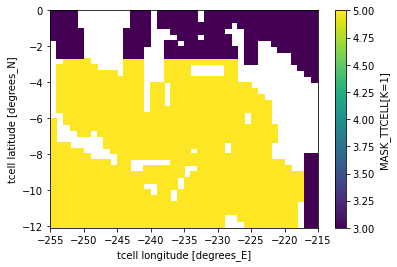

In [26]:
basin_mask = xr.open_mfdataset('/g/data/e14/mv7494/basin_mask_mom_1deg.nc').BASIN_MASK
basin_mask.sel(yt_ocean=slice(-12,0)).sel(xt_ocean=slice(-255,-215)).plot()

# For the ITF, I calculate the heat flux between -255°E and -226°E at 2.667°S (where the temp_yflux grid cell is located) + 
#                          the heat flux between 12°S and 6°S at -218°E

In [29]:
temp_yflux[0,:,:].sel(grid_yu_ocean=-2.667, method='nearest').sel(grid_xt_ocean=slice(-255,-226))

<xarray.DataArray (grid_xt_ocean: 29)>
dask.array<getitem, shape=(29,), dtype=float64, chunksize=(29,), chunktype=numpy.ndarray>
Coordinates:
    time           object 1972-07-02 00:00:00
  * grid_xt_ocean  (grid_xt_ocean) float64 -254.5 -253.5 ... -227.5 -226.5
    grid_yu_ocean  float64 -2.667

### Removing the linear trend in the control and then calculating the linear trend from the residual

In [11]:
%%time
# Test Transect: Southern Ocean into Atlantic + Pacific + Indian
z = np.polyfit(t,a, 1); poly_clim = np.poly1d(z) # linear cntrl trend for 35°S Southern -> Atlantic 
z = np.polyfit(t,b - poly_clim(t), 1); poly1 = np.poly1d(z) # calculate trend of data when clim trend already removed

# Transect  I: Southern Ocean - Atlantic Ocean
z = np.polyfit(t,c, 1); poly_clim = np.poly1d(z)
z = np.polyfit(t,d - poly_clim(t), 1); poly1 = np.poly1d(z)

# Transect  II: Southern Ocean - Pacific Ocean
z = np.polyfit(t,e, 1); poly_clim2 = np.poly1d(z)
z = np.polyfit(t,f - poly_clim2(t), 1); poly2 = np.poly1d(z)

# Transect  III: Southern Ocean - Indian Ocean
z = np.polyfit(t,g, 1); poly_clim3 = np.poly1d(z)
z = np.polyfit(t,h - poly_clim3(t), 1); poly3 = np.poly1d(z)

# Transect IV: Bering Strait
z = np.polyfit(t,i, 1); poly_clim4 = np.poly1d(z) 
z = np.polyfit(t,k - poly_clim4(t), 1); poly4 = np.poly1d(z) 

# Transect V: Indonesian Throughflow
z = np.polyfit(t,l, 1); poly_clim5 = np.poly1d(z) 
z = np.polyfit(t,m - poly_clim5(t), 1); poly4 = np.poly1d(z) 

# Transect VI: Southern Ocean into Indo-Pacific
z = np.polyfit(t,n, 1); poly_clim6 = np.poly1d(z) 
z = np.polyfit(t,o - poly_clim6(t), 1); poly5 = np.poly1d(z) 

CPU times: user 3.56 ms, sys: 1.34 ms, total: 4.9 ms
Wall time: 4.57 ms


### Quickly plotting the basin-wide heat budgets

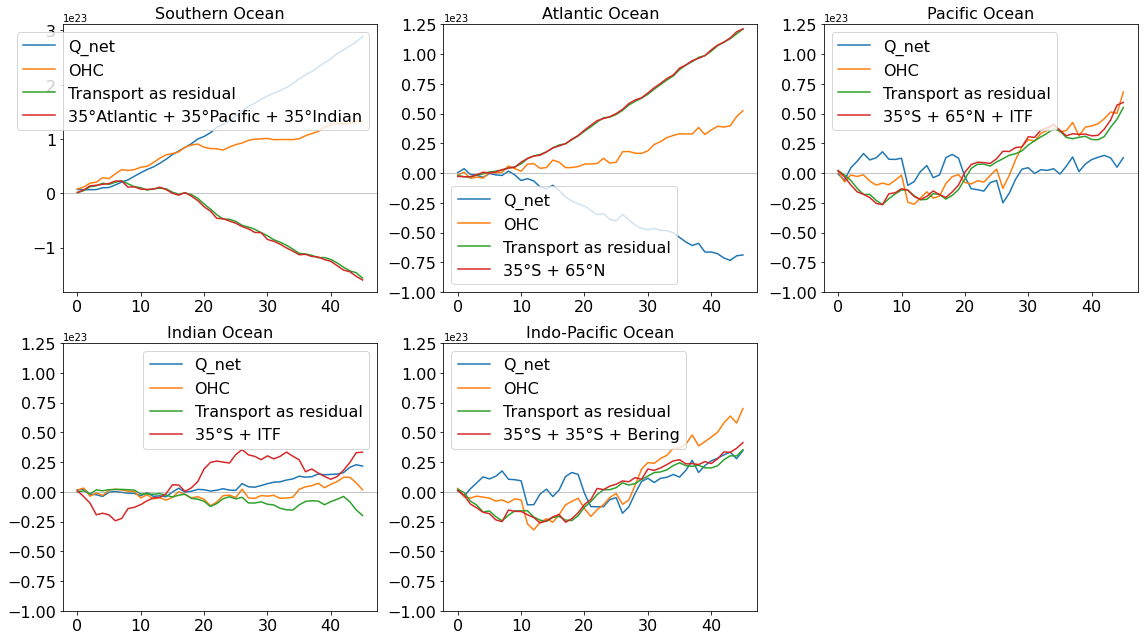

In [16]:
# load in basin-wide OHU and OHC
out = '1deg_jra55_iaf_branch2000_trend/'
run = ['1deg_jra55_iaf_branch2000/','1deg_jra55_iaf_branch2000_trend/']

ds = xr.open_dataset(base+out+'basin_wide_OHC_and_Qnet.nc')
area_t = xr.open_dataset(base+run[0]+'output201/ocean/ocean_grid.nc').area_t
OHC_1deg_global = (ds.OHC_global*area_t).sum(['yt_ocean','xt_ocean'])
Qnet_1deg_global = (ds.Qnet_global*area_t).sum(['yt_ocean','xt_ocean'])
t = np.linspace(0,45,46)
# ---

fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k')

plt.subplot(2,3,1) # --- Southern Ocean
plt.plot((ds.Qnet_Southern*area_t).sum(['yt_ocean','xt_ocean']).values,label='Q_net')
plt.plot((ds.OHC_Southern*area_t).sum(['yt_ocean','xt_ocean']).values,label='OHC')
plt.plot((ds.OHC_Southern*area_t).sum(['yt_ocean','xt_ocean']).values-(ds.Qnet_Southern*area_t).sum(['yt_ocean','xt_ocean']).values, label='Transport as residual')
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.title('Southern Ocean', fontsize=16)
plt.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9); plt.legend(fontsize=16)
plt.plot(t, -((d - poly_clim(t)) + (f - poly_clim2(t)) + (h - poly_clim3(t))), label='35°Atlantic + 35°Pacific + 35°Indian'); plt.legend(fontsize=16)

plt.subplot(2,3,2) # --- Atlantic Ocean
plt.plot((ds.Qnet_Atlantic*area_t).sum(['yt_ocean','xt_ocean']).values,label='Q_net')
plt.plot((ds.OHC_Atlantic*area_t).sum(['yt_ocean','xt_ocean']).values,label='OHC')
plt.plot((ds.OHC_Atlantic*area_t).sum(['yt_ocean','xt_ocean']).values-(ds.Qnet_Atlantic*area_t).sum(['yt_ocean','xt_ocean']).values, label='Transport as residual')
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.title('Atlantic Ocean', fontsize=16)
plt.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9);
plt.plot(t, (d - poly_clim(t)) + (k - poly_clim4(t)), label='35°S + 65°N'); plt.legend(fontsize=16)
plt.ylim(top = 1.25e23, bottom = -1e23)

plt.subplot(2,3,3) # --- Pacific Ocean
plt.plot((ds.Qnet_Pacific*area_t).sum(['yt_ocean','xt_ocean']).values,label='Q_net')
plt.plot((ds.OHC_Pacific*area_t).sum(['yt_ocean','xt_ocean']).values,label='OHC')
plt.plot((ds.OHC_Pacific*area_t).sum(['yt_ocean','xt_ocean']).values-(ds.Qnet_Pacific*area_t).sum(['yt_ocean','xt_ocean']).values,label='Transport as residual')
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.title('Pacific Ocean', fontsize=16)
plt.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9); plt.legend(fontsize=16)
plt.plot(t, (f - poly_clim2(t)) + (k - poly_clim4(t)) + (m - poly_clim5(t)), label='35°S + 65°N + ITF'); plt.legend(fontsize=16)
plt.ylim(top = 1.25e23, bottom = -1e23)

plt.subplot(2,3,4) # --- Indian Ocean
plt.plot((ds.Qnet_Indian*area_t).sum(['yt_ocean','xt_ocean']).values,label='Q_net')
plt.plot((ds.OHC_Indian*area_t).sum(['yt_ocean','xt_ocean']).values,label='OHC')
plt.plot((ds.OHC_Indian*area_t).sum(['yt_ocean','xt_ocean']).values-(ds.Qnet_Indian*area_t).sum(['yt_ocean','xt_ocean']).values, label='Transport as residual')
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.title('Indian Ocean', fontsize=16)
plt.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9); plt.legend(fontsize=16)
plt.plot(t, (h - poly_clim3(t)) + (m - poly_clim5(t)), label='35°S + ITF'); plt.legend(fontsize=16)
plt.ylim(top = 1.25e23, bottom = -1e23)

plt.subplot(2,3,5) # --- Indopacific
plt.plot((ds.Qnet_Indopacific*area_t).sum(['yt_ocean','xt_ocean']).values,label='Q_net')
plt.plot((ds.OHC_Indopacific*area_t).sum(['yt_ocean','xt_ocean']).values,label='OHC')
plt.plot((ds.OHC_Indopacific*area_t).sum(['yt_ocean','xt_ocean']).values-(ds.Qnet_Indopacific*area_t).sum(['yt_ocean','xt_ocean']).values,label='Transport as residual')
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.title('Indo-Pacific Ocean', fontsize=16)
plt.axhline(y= 0, c = 'grey', linewidth = .5, alpha = .9); plt.legend(fontsize=16)
plt.plot(t, (o - poly_clim6(t)) + (k - poly_clim4(t)), label='35°S + 35°S + Bering'); plt.legend(fontsize=16)
plt.ylim(top = 1.25e23, bottom = -1e23)

# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
plt.savefig(save + 'Closing_the_Global_and_Atlantic_heat_budget', dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 1min 40s